### LOAD DATASET

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob 
import time
from datetime import datetime
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import shuffle

from keras.utils import np_utils
from keras.models import Sequential 
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

### DATA PREPROCESSING 

In [2]:
img_h = 224
img_w = 224
def read_img(path,):
    'read, resize, and convert an image to grayscale'
    img = cv2.imread(path)
    resize = cv2.resize(img, (img_h, img_w), cv2.INTER_LINEAR)
    #gray = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)
    return resize

In [3]:
type_paths = glob('/storage/Documents/springboard_capstone/capstone1/train/*')
test_paths = glob('/storage/Documents/springboard_capstone/capstone1/test/*')

In [4]:
train_paths = []
for path in type_paths:
    train_paths += glob(path+'/*')

In [5]:
def load_train(paths):
    train_data = []
    train_target = []
    train_id = []
    start_time = time.time()
    for path in paths:
        train_id.append(path)
        train_data.append(read_img(path))
        target = path.split('/')[-2]
        train_target.append(target)
    print ('Training data load time: {}'.format(time.time() - start_time))
    return train_data, train_target, train_id

def load_test(paths):
    test_data = []
    test_id = []
    start_time = time.time()
    for path in paths:
        test_id.append(path)
        test_data.append(read_img(path))
    print ('Testing data load time: {}'.format(time.time() - start_time))
    return test_data, test_id

In [6]:
train_data, train_target, train_id_ = load_train(train_paths)
test_data, test_id_ = load_test(test_paths)

Training data load time: 288.3324890136719
Testing data load time: 98.37444496154785


In [7]:
def normalize_data(data):
    data = np.array(data, dtype=np.uint8)
    data = data.astype('float32')
    data = data/255
    return data

train_data = normalize_data(train_data)
print ('Shape of the training data is ', train_data.shape)

Shape of the training data is  (1481, 224, 224, 3)


In [8]:
test_data = normalize_data(test_data)
print ('Shape of the training data is ', test_data.shape)

Shape of the training data is  (503, 224, 224, 3)


In [9]:
# Convert train_target to one-hot-encoding before fitting into the model
train_label = [int(x.split('_')[1]) for x in train_target]
train_label = np_utils.to_categorical(train_label)
train_label = np.transpose(train_label)
train_label = np.transpose(train_label[~(train_label==0).all(axis=1)])

In [10]:
# Create validation split 
X_train, X_valid, Y_train, Y_valid = train_test_split(train_data, train_label, test_size=0.2, random_state=22)

### BUILDING MODELS AND  COMPARING MODEL PERFORMANCE

In [11]:
#Training hyperparameters
epochs = 50
batch_size = 16

In [12]:
#Early stopping callback
patience = 4
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.05, 
                              patience = patience, verbose=0, mode='auto')

### Sequential Model with 3 convolution layers with a ReLU activation and max_pooling

In [45]:
#Build the first model with a simple stack of 3 convolution layers with a ReLU activation and max_pooling

model1 = Sequential()
model1.add(Conv2D(32, (3, 3), input_shape=(img_h, img_w, 3), data_format='channels_last', name='block1_Conv2D'))
model1.add(Activation('relu', name='block1_Activation'))
model1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block1_MaxPooling2D'))
model1.add(Dropout(0.25, name='block1_Dropout'))

model1.add(Conv2D(64, (3, 3), data_format='channels_last', name='block2_Conv2D'))
model1.add(Activation('relu', name='block2_Activation'))
model1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block2_MaxPooling2D'))
model1.add(Dropout(0.25, name='block2_Dropout'))

model1.add(Conv2D(128, (3,3), data_format='channels_last', name='block3_Conv2D'))
model1.add(Activation('relu', name='block3_Activation'))
model1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block3_MaxPooling2D'))
model1.add(Dropout(0.25, name='block3_Dropout'))

#Add flatten
model1.add(Flatten(name='block4_Flatten'))
model1.add(Dense(256, activation='relu', name='block4_Dense'))
model1.add(Dropout(0.5, name='block4_Dropout'))
model1.add(Dense(3, activation='softmax', name='block4_Activation'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(loss='categorical_crossentropy', 
             optimizer=sgd,
             metrics = ['accuracy'])

In [46]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_Conv2D (Conv2D)       (None, 222, 222, 32)      896       
_________________________________________________________________
block1_Activation (Activatio (None, 222, 222, 32)      0         
_________________________________________________________________
block1_MaxPooling2D (MaxPool (None, 111, 111, 32)      0         
_________________________________________________________________
block1_Dropout (Dropout)     (None, 111, 111, 32)      0         
_________________________________________________________________
block2_Conv2D (Conv2D)       (None, 109, 109, 64)      18496     
_________________________________________________________________
block2_Activation (Activatio (None, 109, 109, 64)      0         
_________________________________________________________________
block2_MaxPooling2D (MaxPool (None, 54, 54, 64)        0         
__________

In [18]:
start_time = time.time()

model1.fit(X_train, Y_train, 
         batch_size=batch_size, epochs=epochs, 
         callbacks=[early_stopping],
         validation_data=(X_valid, Y_valid), shuffle=True)

end_time = time.time()
print ('The time for fitting training data into model 1 is {}'.format(end_time-start_time))

Train on 1184 samples, validate on 297 samples
Epoch 1/50
1184/1184 [==============================] - 376s 318ms/step - loss: 1.0104 - acc: 0.5312 - val_loss: 1.0173 - val_acc: 0.5118
Epoch 2/50
1184/1184 [==============================] - 357s 302ms/step - loss: 1.0059 - acc: 0.5270 - val_loss: 1.0164 - val_acc: 0.5118
Epoch 3/50
1184/1184 [==============================] - 325s 274ms/step - loss: 0.9942 - acc: 0.5312 - val_loss: 1.0145 - val_acc: 0.5118
Epoch 4/50
1184/1184 [==============================] - 299s 252ms/step - loss: 0.9832 - acc: 0.5321 - val_loss: 1.0087 - val_acc: 0.5118
Epoch 5/50
1184/1184 [==============================] - 282s 238ms/step - loss: 0.9607 - acc: 0.5312 - val_loss: 0.9629 - val_acc: 0.5118
The time for fitting training data into model 1 is 1639.1563205718994


### Very Deep Convolutional NetWorks for Large-Scale Image Recognition (VGG16 Model)

In [23]:
from keras.applications.vgg16 import VGG16
from keras.models import Model 

vgg16_model = VGG16(weights = 'imagenet', include_top=False, 
                   input_shape=(img_w, img_h, 3))

#Freeze all layers in VGG16 model
for layer in vgg16_model.layers:
    layer.trainable = False
    
vgg16_model.compile(loss='categorical_crossentropy', 
             optimizer=sgd,
             metrics = ['accuracy'])

top_model = Sequential()
top_model.add(Flatten(input_shape = vgg16_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(3,activation='softmax'))

model2 = Model(input=vgg16_model.input, output=top_model(vgg16_model.output))
model2.compile(loss='categorical_crossentropy', 
             optimizer=sgd,
             metrics = ['accuracy'])

/home/ives/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  if sys.path[0] == '':


In [24]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [25]:
start_time = time.time()
model2.fit(X_train, Y_train, 
         batch_size=batch_size, epochs=epochs, 
         callbacks=[early_stopping], 
         validation_data=(X_valid, Y_valid), shuffle=True)

end_time = time.time()
print ('The time for fitting training data into model 2 is {}'.format(end_time-start_time))
model2.save_weights('model2.h5')

Train on 1184 samples, validate on 297 samples
Epoch 1/50
1184/1184 [==============================] - 4532s 4s/step - loss: 12.7385 - acc: 0.1934 - val_loss: 13.1875 - val_acc: 0.1818
Epoch 2/50
1184/1184 [==============================] - 4646s 4s/step - loss: 13.3410 - acc: 0.1723 - val_loss: 13.1875 - val_acc: 0.1818
Epoch 3/50
1184/1184 [==============================] - 4649s 4s/step - loss: 13.4499 - acc: 0.1655 - val_loss: 13.1875 - val_acc: 0.1818
Epoch 4/50
1184/1184 [==============================] - 5276s 4s/step - loss: 13.4635 - acc: 0.1647 - val_loss: 13.1875 - val_acc: 0.1818
Epoch 5/50
1184/1184 [==============================] - 5414s 5s/step - loss: 13.3818 - acc: 0.1698 - val_loss: 13.1875 - val_acc: 0.1818
The time for fitting training data into model 2 is 24517.816619873047


### ResNet Model

In [26]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model 

resnet50_model = ResNet50(weights = 'imagenet', include_top=False, 
                   input_shape=(img_w, img_h, 3))

#Freeze all layers in resnet50 model
for layer in resnet50_model.layers:
    layer.trainable = False
resnet50_model.compile(loss='categorical_crossentropy', 
             optimizer=sgd,
             metrics = ['accuracy'])

add_model = Sequential()
add_model.add(Flatten(input_shape =resnet50_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dropout(0.5))
add_model.add(Dense(3,activation='softmax'))

model3 = Model(input=resnet50_model.input, output=add_model(resnet50_model.output))
model3.compile(loss='categorical_crossentropy', 
             optimizer=sgd,
             metrics = ['accuracy'])

/home/ives/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/ives/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  if sys.path[0] == '':


In [27]:
start_time = time.time()
model3.fit(X_train, Y_train, 
         batch_size=batch_size, epochs=epochs, 
         callbacks=[early_stopping], 
         validation_data=(X_valid, Y_valid), shuffle=True)

end_time = time.time()
print ('The time for fitting training data into model 3 is {}'.format(end_time-start_time))

model3.save_weights('model3.h5')

Train on 1184 samples, validate on 297 samples
Epoch 1/50
1184/1184 [==============================] - 3016s 3s/step - loss: 7.5120 - acc: 0.5270 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 2/50
1184/1184 [==============================] - 2855s 2s/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 3/50
1184/1184 [==============================] - 2537s 2s/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 4/50
1184/1184 [==============================] - 2509s 2s/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 5/50
1184/1184 [==============================] - 2553s 2s/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
The time for fitting training data into model 3 is 13474.341937065125


### TUNING THE NUMBER OF EPOCHS AND THE NUMBER OF LAYERS FOR MODEL1 

####  Determine the number of epochs for training model1

In [20]:
def add_layer_to_model1(n_layers):
    model = Sequential()
    kernel_size=(3,3)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(img_h, img_w, 3), data_format='channels_last', name='block1_Conv2D'))
    model.add(Activation('relu', name='block1_Activation'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block1_MaxPooling2D'))
    model.add(Dropout(0.25, name='block1_Dropout'))

    model.add(Conv2D(64, (3, 3), data_format='channels_last', name='block2_Conv2D'))
    model.add(Activation('relu', name='block2_Activation'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block2_MaxPooling2D'))
    model.add(Dropout(0.25, name='block2_Dropout'))

    model.add(Conv2D(128, (3,3), data_format='channels_last', name='block3_Conv2D'))
    model.add(Activation('relu', name='block3_Activation'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block3_MaxPooling2D'))
    model.add(Dropout(0.25, name='block3_Dropout'))
    
    for i in range(n_layers):
        model.add(Conv2D(128, kernel_size, data_format='channels_last', name='added_layer_{}1'.format(str(i+1))))
        model.add(Activation('relu', name='added_layer_{}2'.format(str(i+1))))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='added_layer_{}3'.format(str(i+1))))
        model.add(Dropout(0.25, name='added_layer_{}4'.format(str(i+1))))
            
    #Add flatten
    model.add(Flatten(name='block4_Flatten'))
    model.add(Dense(256, activation='relu', name='block4_Dense'))
    model.add(Dropout(0.5, name='block4_Dropout'))
    model.add(Dense(3, activation='softmax', name='block4_Activation'))
        

    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='categorical_crossentropy', optimizer = sgd, 
                 metrics=['accuracy'])
    return model

In [21]:
model1 = add_layer_to_model1(0)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_Conv2D (Conv2D)       (None, 222, 222, 32)      896       
_________________________________________________________________
block1_Activation (Activatio (None, 222, 222, 32)      0         
_________________________________________________________________
block1_MaxPooling2D (MaxPool (None, 111, 111, 32)      0         
_________________________________________________________________
block1_Dropout (Dropout)     (None, 111, 111, 32)      0         
_________________________________________________________________
block2_Conv2D (Conv2D)       (None, 109, 109, 64)      18496     
_________________________________________________________________
block2_Activation (Activatio (None, 109, 109, 64)      0         
_________________________________________________________________
block2_MaxPooling2D (MaxPool (None, 54, 54, 64)        0         
__________

In [22]:
modelcheckpoint = ModelCheckpoint('model1_checkpoint/checking_epochs_model1.h5', 
                                  monitor='val_acc', 
                                  verbose=0,
                                  save_best_only=True, 
                                  mode='auto', period=1)
history_model1 = model1.fit(X_train, Y_train, 
                       batch_size=batch_size, 
                       epochs=epochs, 
                       callbacks=[modelcheckpoint], 
                       validation_data=[X_valid, Y_valid])

model1.save('model1_checkpoint/model1_add_0_layer.h5')

Train on 1184 samples, validate on 297 samples
Epoch 1/50
1184/1184 [==============================] - 194s 164ms/step - loss: 1.0256 - acc: 0.5262 - val_loss: 1.0222 - val_acc: 0.5118
Epoch 2/50
1184/1184 [==============================] - 204s 172ms/step - loss: 1.0006 - acc: 0.5312 - val_loss: 1.0234 - val_acc: 0.5118
Epoch 3/50
1184/1184 [==============================] - 206s 174ms/step - loss: 0.9999 - acc: 0.5312 - val_loss: 1.0168 - val_acc: 0.5118
Epoch 4/50
1184/1184 [==============================] - 200s 169ms/step - loss: 1.0002 - acc: 0.5312 - val_loss: 1.0151 - val_acc: 0.5118
Epoch 5/50
1184/1184 [==============================] - 204s 172ms/step - loss: 0.9952 - acc: 0.5312 - val_loss: 1.0162 - val_acc: 0.5118
Epoch 6/50
1184/1184 [==============================] - 203s 171ms/step - loss: 0.9962 - acc: 0.5312 - val_loss: 1.0122 - val_acc: 0.5118
Epoch 7/50
1184/1184 [==============================] - 204s 172ms/step - loss: 0.9953 - acc: 0.5312 - val_loss: 1.0140 - val

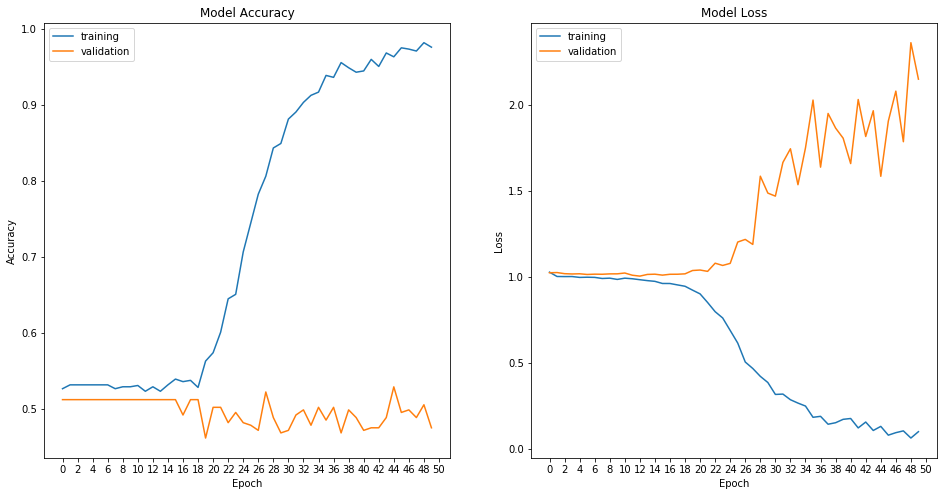

In [50]:
% matplotlib inline

model1_val_acc = history_model1.history['val_acc']
model1_acc = history_model1.history['acc']
model1_val_loss = history_model1.history['val_loss']
model1_loss = history_model1.history['loss']

fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1, 2, 1)
ax1.plot(model1_acc, label='training')
ax1.plot(model1_val_acc, label='validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_xticks(range(0,52,2))
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

ax2 = fig1.add_subplot(1, 2, 2)
ax2.plot(model1_loss, label='training')
ax2.plot(model1_val_loss, label='validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')
ax2.set_xticks(range(0,52,2))

plt.show()

In [24]:
epochs = 17

valid_losses = []
valid_accuracies = []
train_losses = []
train_accuracies = []
histories = []

for i in range(1, 4):
    new_model1 = add_layer_to_model1(i)
    print ('Adding {}'.format(str(i)), 'layer into model 1')
    print (new_model1.summary())
    modelcheckpoint = ModelCheckpoint('model1_checkpoint/Model1-add-{}-layer.h5'.format(str(i)), 
                                        monitor='val_acc', 
                                        verbose=0, save_best_only=True,  
                                        mode='auto', period=1)

    history = new_model1.fit(X_train, Y_train, 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   callbacks=[modelcheckpoint], 
                   validation_data=[X_valid, Y_valid])
    
    histories.append(history)
    
    valid_loss, valid_accuracy = new_model1.evaluate(X_valid, Y_valid)
    train_loss, train_accuracy = new_model1.evaluate(X_train, Y_train)
    
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

Adding 1 layer into model 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_Conv2D (Conv2D)       (None, 222, 222, 32)      896       
_________________________________________________________________
block1_Activation (Activatio (None, 222, 222, 32)      0         
_________________________________________________________________
block1_MaxPooling2D (MaxPool (None, 111, 111, 32)      0         
_________________________________________________________________
block1_Dropout (Dropout)     (None, 111, 111, 32)      0         
_________________________________________________________________
block2_Conv2D (Conv2D)       (None, 109, 109, 64)      18496     
_________________________________________________________________
block2_Activation (Activatio (None, 109, 109, 64)      0         
_________________________________________________________________
block2_MaxPooling2D (MaxPool (None, 54, 54, 64) 

Train on 1184 samples, validate on 297 samples
Epoch 1/17
1184/1184 [==============================] - 219s 185ms/step - loss: 1.0216 - acc: 0.5194 - val_loss: 1.0187 - val_acc: 0.5118
Epoch 2/17
1184/1184 [==============================] - 218s 184ms/step - loss: 1.0046 - acc: 0.5321 - val_loss: 1.0174 - val_acc: 0.5118
Epoch 3/17
1184/1184 [==============================] - 218s 184ms/step - loss: 1.0003 - acc: 0.5312 - val_loss: 1.0153 - val_acc: 0.5118
Epoch 4/17
1184/1184 [==============================] - 216s 183ms/step - loss: 0.9987 - acc: 0.5312 - val_loss: 1.0156 - val_acc: 0.5118
Epoch 5/17
1184/1184 [==============================] - 218s 184ms/step - loss: 0.9968 - acc: 0.5312 - val_loss: 1.0181 - val_acc: 0.5118
Epoch 6/17
1184/1184 [==============================] - 218s 184ms/step - loss: 0.9996 - acc: 0.5312 - val_loss: 1.0177 - val_acc: 0.5118
Epoch 7/17
1184/1184 [==============================] - 220s 186ms/step - loss: 1.0023 - acc: 0.5312 - val_loss: 1.0156 - val

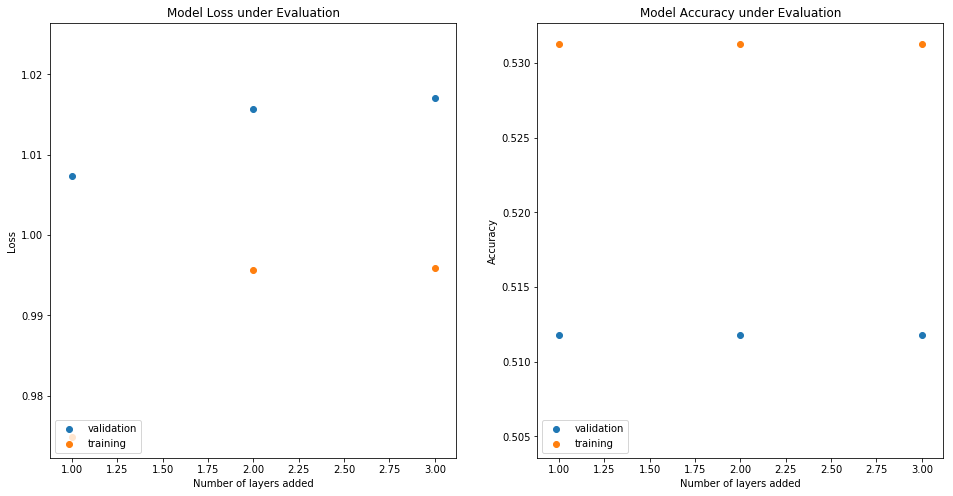

In [51]:
nb_layers = [1, 2, 3]
fig2 = plt.figure(figsize=(16,8))
ax1 = fig2.add_subplot(1,2,1)
ax1.scatter(nb_layers, valid_losses, label='validation')
ax1.scatter(nb_layers, train_losses, label='training')
ax1.set_xlabel('Number of layers added')
ax1.set_ylabel('Loss')
ax1.set_title('Model Loss under Evaluation')
ax1.legend(loc='lower left')

ax2 = fig2.add_subplot(1,2,2)
ax2.scatter(nb_layers, valid_accuracies, label='validation')
ax2.scatter(nb_layers, train_accuracies, label='training')
ax2.set_xlabel('Number of layers added')
ax2.set_ylabel('Accuracy')
ax2.set_title('Model Accuracy under Evaluation')
ax2.legend(loc='lower left')

### TUNING ON MODEL 1 USING DIFFERENT ACTIVATION METHOD

In [37]:
def build_model1(activate):
    model = Sequential()
    kernel_size=(3,3)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(img_h, img_w, 3), data_format='channels_last', name='block1_Conv2D'))
    model.add(Activation(activate, name='block1_Activation'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block1_MaxPooling2D'))
    model.add(Dropout(0.25, name='block1_Dropout'))

    model.add(Conv2D(64, (3, 3), data_format='channels_last', name='block2_Conv2D'))
    model.add(Activation(activate, name='block2_Activation'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block2_MaxPooling2D'))
    model.add(Dropout(0.25, name='block2_Dropout'))

    model.add(Conv2D(128, (3,3), data_format='channels_last', name='block3_Conv2D'))
    model.add(Activation(activate, name='block3_Activation'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block3_MaxPooling2D'))
    model.add(Dropout(0.25, name='block3_Dropout'))
    
    
    #Add flatten
    model.add(Flatten(name='block4_Flatten'))
    model.add(Dense(256, activation=activate, name='block4_Dense'))
    model.add(Dropout(0.5, name='block4_Dropout'))
    model.add(Dense(3, activation='softmax', name='block4_Activation'))
        

    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='categorical_crossentropy', optimizer = sgd, 
                 metrics=['accuracy'])
    return model

In [84]:
activation_list = [ 'elu', 'softplus', 'sigmoid', 'linear']

In [47]:
new_activation_valid_losses= []
new_activation_valid_accuracies = []
new_activation_train_losses = []
new_activation_train_accuracies = []
histories_new_activation = []

for activate in activation_list:
    print ('Activation: ', activate)
    new_activation_model1 = build_model1(activate)
    modelcheckpoint = ModelCheckpoint('model1_checkpoint/Model1-activation-{}.h5'.format(str(activate)), 
                                        monitor='val_acc', 
                                        verbose=0, save_best_only=True,  
                                        mode='auto', period=1)

    history_new_activate = new_activation_model1.fit(X_train, Y_train, 
                   batch_size=batch_size, 
                   epochs=17, 
                   callbacks=[modelcheckpoint], 
                   validation_data=[X_valid, Y_valid])
    
    histories_new_activation.append(history_new_activate)
    
    valid_loss_new_activate, valid_accuracy_new_activate = new_activation_model1.evaluate(X_valid, Y_valid)
    train_loss_new_activate, train_accuracy_new_activate = new_activation_model1.evaluate(X_train, Y_train)
    
    new_activation_valid_losses.append(valid_loss_new_activate)
    new_activation_valid_accuracies.append(valid_accuracy_new_activate)
    
    new_activation_train_losses.append(train_loss_new_activate)
    new_activation_train_accuracies.append(train_accuracy_new_activate)

Activation:  elu
Train on 1184 samples, validate on 297 samples
Epoch 1/17
1184/1184 [==============================] - 503s 425ms/step - loss: 7.4885 - acc: 0.5279 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 2/17
1184/1184 [==============================] - 498s 421ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 3/17
1184/1184 [==============================] - 487s 411ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 4/17
1184/1184 [==============================] - 493s 416ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 5/17
1184/1184 [==============================] - 488s 412ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 6/17
1184/1184 [==============================] - 492s 415ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 7/17
1184/1184 [==============================] - 487s 412ms/step - loss: 7.5554 - acc: 0.5312 - val_l

In [75]:
model1_relu_valid_loss, model1_relu_valid_accuracy = model1.evaluate(X_valid, Y_valid)
model1_relu_train_loss, model1_relu_train_accuracy = model1.evaluate(X_train, Y_train)

new_activation_valid_losses.append(model1_relu_valid_loss)
new_activation_train_losses.append(model1_relu_train_loss)
new_activation_valid_accuracies.append(model1_relu_valid_accuracy)
new_activation_train_accuracies.append(model1_relu_train_accuracy)
activation_list.append('relu')

1184/1184 [==============================] - 47s 40ms/step


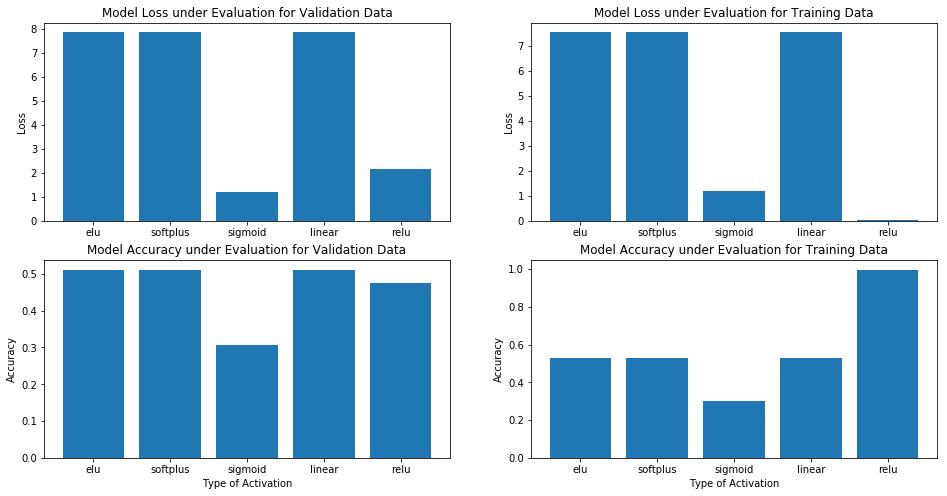

In [93]:
fig3 = plt.figure(figsize=(16,8))
ax1 = fig3.add_subplot(2,2,1)
ax1.bar(activation_list, new_activation_valid_losses, label='validation')
ax2 = fig3.add_subplot(2,2,2)
ax2.bar(activation_list, new_activation_train_losses, label='training')
ax1.set_ylabel('Loss')
ax1.set_title('Model Loss under Evaluation for Validation Data')
ax2.set_ylabel('Loss')
ax2.set_title('Model Loss under Evaluation for Training Data')

ax3= fig3.add_subplot(2,2,3)
ax3.bar(activation_list, new_activation_valid_accuracies, label='validation')
ax4= fig3.add_subplot(2,2,4)
ax4.bar(activation_list, new_activation_train_accuracies, label='training')
ax3.set_xlabel('Type of Activation')
ax3.set_ylabel('Accuracy')
ax3.set_title('Model Accuracy under Evaluation for Validation Data')
ax4.set_xlabel('Type of Activation')
ax4.set_ylabel('Accuracy')
ax4.set_title('Model Accuracy under Evaluation for Training Data')

### TESTING MODEL1 PERFORMANCE BY REDUCING THE NUMBER OF FEATURES

In [33]:
def reduced_feature_model1(min_num, max_num):
    model = Sequential()
    kernel_size=(3,3)
    for i in range(min_num, max_num):
        model.add(Conv2D(2**i, (3, 3), input_shape=(img_h, img_w, 3), data_format='channels_last'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
        model.add(Dropout(0.25))

    
    #Add flatten
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5, name='block4_Dropout'))
    model.add(Dense(3, activation='softmax'))
        

    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='categorical_crossentropy', optimizer = sgd, 
                 metrics=['accuracy'])
    return model

In [34]:
reduced_feature_model1 = reduced_feature_model1(3, 6)
reduced_feature_model1.summary()
modelcheckpoint = ModelCheckpoint('model1_checkpoint/Model1-reduced_features.h5',
                                  monitor='val_acc', 
                                  verbose=0, save_best_only=True,  
                                  mode='auto', period=1)

history_reduced_features = reduced_feature_model1.fit(X_train, Y_train, 
               batch_size=batch_size, 
               epochs=50, 
               callbacks=[modelcheckpoint], 
               validation_data=[X_valid, Y_valid])


valid_loss_reduced_features, valid_accuracy_reduced_features = reduced_feature_model1.evaluate(X_valid, Y_valid)
train_loss_reduced_features, train_accuracy_reduced_features = reduced_feature_model1.evaluate(X_train, Y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 222, 222, 8)       224       
_________________________________________________________________
activation_16 (Activation)   (None, 222, 222, 8)       0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 111, 111, 8)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 109, 109, 16)      1168      
_________________________________________________________________
activation_17 (Activation)   (None, 109, 109, 16)      0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 54, 54, 16)        0         
__________

1184/1184 [==============================] - 38s 32ms/step - loss: 0.4894 - acc: 0.7990 - val_loss: 1.0119 - val_acc: 0.5185
Epoch 43/50
1184/1184 [==============================] - 43s 37ms/step - loss: 0.4352 - acc: 0.8260 - val_loss: 1.1541 - val_acc: 0.4949
Epoch 44/50
1184/1184 [==============================] - 40s 34ms/step - loss: 0.3963 - acc: 0.8294 - val_loss: 1.2618 - val_acc: 0.5253
Epoch 45/50
1184/1184 [==============================] - 42s 35ms/step - loss: 0.3760 - acc: 0.8590 - val_loss: 1.2398 - val_acc: 0.4916
Epoch 46/50
1184/1184 [==============================] - 43s 37ms/step - loss: 0.3850 - acc: 0.8530 - val_loss: 1.3154 - val_acc: 0.4815
Epoch 47/50
1184/1184 [==============================] - 42s 35ms/step - loss: 0.3511 - acc: 0.8606 - val_loss: 1.3821 - val_acc: 0.5084
Epoch 48/50
1184/1184 [==============================] - 42s 35ms/step - loss: 0.3037 - acc: 0.8826 - val_loss: 1.4053 - val_acc: 0.5556
Epoch 49/50
1184/1184 [==============================

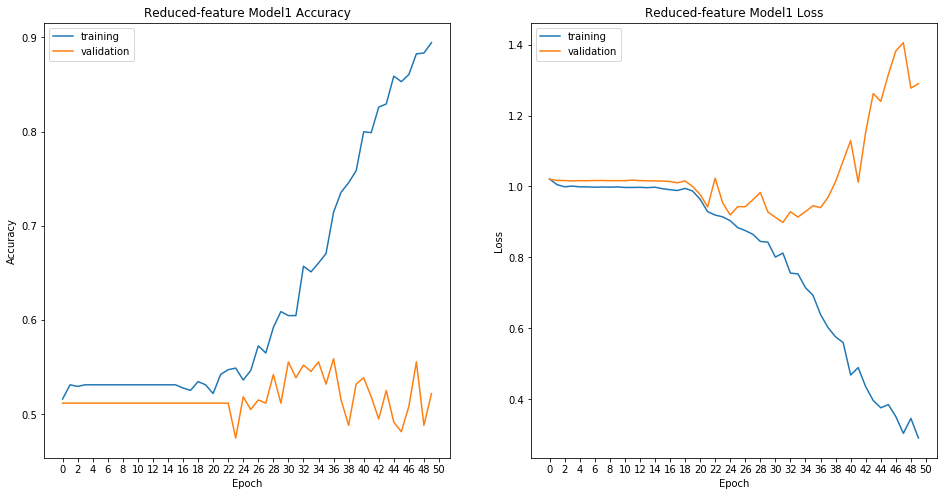

In [35]:
fig4 = plt.figure(figsize=(16,8))
ax1 = fig4.add_subplot(1, 2, 1)
ax1.plot(history_reduced_features.history['acc'], label='training')
ax1.plot(history_reduced_features.history['val_acc'], label='validation')
ax1.set_title('Reduced-feature Model1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_xticks(range(0,52,2))
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

ax2 = fig4.add_subplot(1, 2, 2)
ax2.plot(history_reduced_features.history['loss'], label='training')
ax2.plot(history_reduced_features.history['val_loss'], label='validation')
ax2.set_title('Reduced-feature Model1 Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')
ax2.set_xticks(range(0,52,2))

plt.show()

### TUNING MODEL1 ON DIFFERENT COMBINATION OF OPTIMIZER AND LOSS FUNCTION

In [40]:
def model1_test_combination(loss_function, optimizer):
    model = Sequential()
    kernel_size=(3,3)
    for i in range(3, 6):
        model.add(Conv2D(2**i, (3, 3), input_shape=(img_h, img_w, 3), data_format='channels_last'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
        model.add(Dropout(0.25))

    
    #Add flatten
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5, name='block4_Dropout'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss=loss_function, optimizer = optimizer, 
                 metrics=['accuracy'])   
    return model

In [41]:
from keras import optimizers
loss_functions = ['mean_squared_error', 
                 'categorical_crossentropy', 
                 'binary_crossentropy']

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adadelta = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

optimizers = [sgd, adadelta, adam]

In [42]:
combinations = [loss_functions, optimizers]
import itertools
combinations = list(itertools.product(*combinations))
print ('The number of combinations is ', len(combinations))

The number of combinations is  9


In [53]:
test_combination_histories = []
test_combination_val_scores = []
test_combination_val_accs = []
test_combination_train_scores = []
test_combination_train_accs = []

for i in range(len(combinations)):
    loss_function = combinations[i][0]
    optimizer = combinations[i][1]
    print ('Loss function: ', loss_function)
    print ('Optimizer: ', optimizer)
    start_time = time.time()
    model = model1_test_combination(loss_function, optimizer)
    modelcheckpoint = ModelCheckpoint('model1_checkpoint/Model1-reduced-feature-{}.h5'.format(str(combinations[i])), 
                                            monitor='val_acc', 
                                            verbose=0, save_best_only=True,  
                                            mode='auto', period=1)
    model_history = model.fit(X_train, Y_train, 
              batch_size=batch_size, 
             epochs=20, 
             callbacks=[modelcheckpoint], 
             validation_data=[X_valid, Y_valid])
    test_combination_histories.append(model_history)
    
    train_score, train_acc = model.evaluate(X_train, Y_train)
    test_combination_train_scores.append(train_score)
    test_combination_train_accs.append(train_acc)
    
    val_score, val_acc = model.evaluate(X_valid, Y_valid)
    test_combination_val_scores.append(val_score)
    test_combination_val_accs.append(val_acc)
    
    print ('Training time for this model is {}'.format(time.time()-start_time))
    print ('')
    print ('')

Loss function:  mean_squared_error
Optimizer:  <keras.optimizers.SGD object at 0x2ad686f8a5f8>
Train on 1184 samples, validate on 297 samples
Epoch 1/20
1184/1184 [==============================] - 40s 34ms/step - loss: 0.2071 - acc: 0.5177 - val_loss: 0.2083 - val_acc: 0.5118
Epoch 2/20
1184/1184 [==============================] - 40s 34ms/step - loss: 0.2019 - acc: 0.5296 - val_loss: 0.2075 - val_acc: 0.5118
Epoch 3/20
1184/1184 [==============================] - 38s 32ms/step - loss: 0.2010 - acc: 0.5296 - val_loss: 0.2062 - val_acc: 0.5118
Epoch 4/20
1184/1184 [==============================] - 40s 33ms/step - loss: 0.1996 - acc: 0.5338 - val_loss: 0.2069 - val_acc: 0.5118
Epoch 5/20
1184/1184 [==============================] - 39s 33ms/step - loss: 0.1988 - acc: 0.5312 - val_loss: 0.2076 - val_acc: 0.5118
Epoch 6/20
1184/1184 [==============================] - 39s 33ms/step - loss: 0.1956 - acc: 0.5296 - val_loss: 0.2052 - val_acc: 0.5118
Epoch 7/20
1184/1184 [====================

1184/1184 [==============================] - 42s 36ms/step - loss: 0.3125 - acc: 0.5312 - val_loss: 0.3255 - val_acc: 0.5118
Epoch 16/20
1184/1184 [==============================] - 43s 37ms/step - loss: 0.3125 - acc: 0.5312 - val_loss: 0.3255 - val_acc: 0.5118
Epoch 17/20
1184/1184 [==============================] - 42s 36ms/step - loss: 0.3125 - acc: 0.5312 - val_loss: 0.3255 - val_acc: 0.5118
Epoch 18/20
1184/1184 [==============================] - 42s 35ms/step - loss: 0.3125 - acc: 0.5312 - val_loss: 0.3255 - val_acc: 0.5118
Epoch 19/20
1184/1184 [==============================] - 43s 36ms/step - loss: 0.3125 - acc: 0.5312 - val_loss: 0.3255 - val_acc: 0.5118
Epoch 20/20
297/297 [==============================] - 2s 7ms/step
Training time for this model is 876.2362463474274


Loss function:  categorical_crossentropy
Optimizer:  <keras.optimizers.SGD object at 0x2ad686f8a5f8>
Train on 1184 samples, validate on 297 samples
Epoch 1/20
1184/1184 [==============================] - 40s 

1184/1184 [==============================] - 42s 36ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 9/20
1184/1184 [==============================] - 41s 35ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 10/20
1184/1184 [==============================] - 42s 35ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 11/20
1184/1184 [==============================] - 44s 37ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 12/20
1184/1184 [==============================] - 42s 35ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 13/20
1184/1184 [==============================] - 43s 36ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 14/20
1184/1184 [==============================] - 42s 35ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 15/20
1184/1184 [==============================]

1184/1184 [==============================] - 44s 37ms/step - loss: 0.9653 - acc: 0.6754 - val_loss: 0.5951 - val_acc: 0.6667
Epoch 2/20
1184/1184 [==============================] - 42s 35ms/step - loss: 0.5853 - acc: 0.6881 - val_loss: 0.5949 - val_acc: 0.6745
Epoch 3/20
1184/1184 [==============================] - 41s 35ms/step - loss: 0.5857 - acc: 0.6867 - val_loss: 0.5947 - val_acc: 0.6745
Epoch 4/20
1184/1184 [==============================] - 44s 37ms/step - loss: 0.5859 - acc: 0.6802 - val_loss: 0.5947 - val_acc: 0.6745
Epoch 5/20
1184/1184 [==============================] - 41s 35ms/step - loss: 0.5869 - acc: 0.6779 - val_loss: 0.5949 - val_acc: 0.6745
Epoch 6/20
1184/1184 [==============================] - 43s 37ms/step - loss: 0.5867 - acc: 0.6791 - val_loss: 0.5952 - val_acc: 0.6745
Epoch 7/20
1184/1184 [==============================] - 41s 35ms/step - loss: 0.5856 - acc: 0.6881 - val_loss: 0.5947 - val_acc: 0.6745
Epoch 8/20
1184/1184 [==============================] - 42s

In [55]:
best_acc = max(test_combination_val_accs)
best_acc_idx = test_combination_val_accs.index(best_acc)
best_combo = combinations[best_acc_idx]
print ('The best loss-function/optimizer combination is ', combinations[best_acc_idx])

The best loss-function/optimizer combination is  ('binary_crossentropy', <keras.optimizers.SGD object at 0x2ad686f8a5f8>)


### FURTHER REDUCING NUMBER OF FEATURES

In [56]:
def build_model1_reduced_feature(loss_function, optimizer):
    model = Sequential()
    kernel_size=(3,3)
    data_size=(224,224,3)
    for i in range(5, 8):
        model.add(Conv2D(2^i, kernel_size, input_shape=data_size, data_format='channels_last'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
        model.add(Dropout(0.25))
        
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss=loss_function, optimizer = optimizer, 
                 metrics=['accuracy'])
    return model

In [60]:
test_combination_histories = []
test_combination_val_scores = []
test_combination_val_accs = []
test_combination_train_scores = []
test_combination_train_accs = []

for i in range(len(combinations)):
    loss_function = combinations[i][0]
    optimizer = combinations[i][1]
    print ('Loss function: ', loss_function)
    print ('Optimizer: ', optimizer)
    start_time = time.time()
    model = build_model1_reduced_feature(loss_function, optimizer)
    print (model.summary())
    modelcheckpoint = ModelCheckpoint('model1_checkpoint/Model1-reduced-feature-version2{}.h5'.format(str(combinations[i])), 
                                            monitor='val_acc', 
                                            verbose=0, save_best_only=True,  
                                            mode='auto', period=1)
    model_history = model.fit(X_train, Y_train, 
              batch_size=batch_size, 
             epochs=20, 
             callbacks=[modelcheckpoint], 
             validation_data=[X_valid, Y_valid])
    test_combination_histories.append(model_history)
    
    train_score, train_acc = model.evaluate(X_train, Y_train)
    test_combination_train_scores.append(train_score)
    test_combination_train_accs.append(train_acc)
    
    val_score, val_acc = model.evaluate(X_valid, Y_valid)
    test_combination_val_scores.append(val_score)
    test_combination_val_accs.append(val_acc)
    
    print ('Training time for this model is {}'.format(time.time()-start_time))
    print ('')
    print ('')

Loss function:  mean_squared_error
Optimizer:  <keras.optimizers.SGD object at 0x2ad686f8a5f8>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 222, 222, 7)       196       
_________________________________________________________________
activation_91 (Activation)   (None, 222, 222, 7)       0         
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 111, 111, 7)       0         
_________________________________________________________________
dropout_94 (Dropout)         (None, 111, 111, 7)       0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 109, 109, 4)       256       
_________________________________________________________________
activation_92 (Activation)   (None, 109, 109, 4)       0         
_______________________________________________

Epoch 2/20
1184/1184 [==============================] - 31s 26ms/step - loss: 0.1948 - acc: 0.5262 - val_loss: 0.1962 - val_acc: 0.5421
Epoch 3/20
1184/1184 [==============================] - 30s 25ms/step - loss: 0.1870 - acc: 0.5490 - val_loss: 0.1926 - val_acc: 0.5253
Epoch 4/20
1184/1184 [==============================] - 32s 27ms/step - loss: 0.1831 - acc: 0.5735 - val_loss: 0.1907 - val_acc: 0.5488
Epoch 5/20
1184/1184 [==============================] - 30s 26ms/step - loss: 0.1797 - acc: 0.5709 - val_loss: 0.1904 - val_acc: 0.5421
Epoch 6/20
1184/1184 [==============================] - 32s 27ms/step - loss: 0.1720 - acc: 0.6115 - val_loss: 0.1899 - val_acc: 0.5354
Epoch 7/20
1184/1184 [==============================] - 31s 26ms/step - loss: 0.1692 - acc: 0.6081 - val_loss: 0.1887 - val_acc: 0.5421
Epoch 8/20
1184/1184 [==============================] - 32s 27ms/step - loss: 0.1683 - acc: 0.6090 - val_loss: 0.1876 - val_acc: 0.5690
Epoch 9/20
1184/1184 [==========================

297/297 [==============================] - 3s 10ms/step
Training time for this model is 695.8240644931793


Loss function:  categorical_crossentropy
Optimizer:  <keras.optimizers.SGD object at 0x2ad686f8a5f8>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 222, 222, 7)       196       
_________________________________________________________________
activation_100 (Activation)  (None, 222, 222, 7)       0         
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 111, 111, 7)       0         
_________________________________________________________________
dropout_106 (Dropout)        (None, 111, 111, 7)       0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 109, 109, 4)       256       
_________________________________________________________________

1184/1184 [==============================] - 34s 29ms/step - loss: 7.4917 - acc: 0.5236 - val_loss: 7.8670 - val_acc: 0.5118
Epoch 2/20
1184/1184 [==============================] - 32s 27ms/step - loss: 7.5011 - acc: 0.5253 - val_loss: 4.0457 - val_acc: 0.5118
Epoch 3/20
1184/1184 [==============================] - 32s 27ms/step - loss: 1.3769 - acc: 0.4806 - val_loss: 1.0852 - val_acc: 0.5118
Epoch 4/20
1184/1184 [==============================] - 32s 27ms/step - loss: 0.9986 - acc: 0.5304 - val_loss: 1.0805 - val_acc: 0.5118
Epoch 5/20
1184/1184 [==============================] - 32s 27ms/step - loss: 0.9946 - acc: 0.5262 - val_loss: 1.0711 - val_acc: 0.5118
Epoch 6/20
1184/1184 [==============================] - 32s 27ms/step - loss: 0.9825 - acc: 0.5363 - val_loss: 1.0759 - val_acc: 0.5084
Epoch 7/20
1184/1184 [==============================] - 32s 27ms/step - loss: 0.9779 - acc: 0.5287 - val_loss: 1.0559 - val_acc: 0.5118
Epoch 8/20
1184/1184 [==============================] - 33s

297/297 [==============================] - 3s 9ms/step
Training time for this model is 668.5347561836243


Loss function:  binary_crossentropy
Optimizer:  <keras.optimizers.SGD object at 0x2ad686f8a5f8>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_109 (Conv2D)          (None, 222, 222, 7)       196       
_________________________________________________________________
activation_109 (Activation)  (None, 222, 222, 7)       0         
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 111, 111, 7)       0         
_________________________________________________________________
dropout_118 (Dropout)        (None, 111, 111, 7)       0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 109, 109, 4)       256       
_________________________________________________________________
activ

Train on 1184 samples, validate on 297 samples
Epoch 1/20
1184/1184 [==============================] - 35s 30ms/step - loss: 0.6648 - acc: 0.6765 - val_loss: 0.6199 - val_acc: 0.6667
Epoch 2/20
1184/1184 [==============================] - 32s 27ms/step - loss: 0.5862 - acc: 0.6886 - val_loss: 0.6175 - val_acc: 0.6667
Epoch 3/20
1184/1184 [==============================] - 33s 27ms/step - loss: 0.5856 - acc: 0.6903 - val_loss: 0.6157 - val_acc: 0.6667
Epoch 4/20
1184/1184 [==============================] - 35s 29ms/step - loss: 0.5734 - acc: 0.6957 - val_loss: 0.6119 - val_acc: 0.6667
Epoch 5/20
1184/1184 [==============================] - 33s 28ms/step - loss: 0.5700 - acc: 0.6976 - val_loss: 0.6121 - val_acc: 0.6633
Epoch 6/20
1184/1184 [==============================] - 34s 29ms/step - loss: 0.5639 - acc: 0.7055 - val_loss: 0.6095 - val_acc: 0.6633
Epoch 7/20
1184/1184 [==============================] - 33s 28ms/step - loss: 0.5537 - acc: 0.7148 - val_loss: 0.6096 - val_acc: 0.6622
E

297/297 [==============================] - 3s 9ms/step
Training time for this model is 671.8640649318695




In [81]:
combo_names = []
for combination in combinations:
    optimizer_name = str(combination[1]).split()[0].split('.')[2]
    loss_func = combination[0]
    combo_name = (loss_func, optimizer_name)
    combo_names.append(combo_name)

/home/ives/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


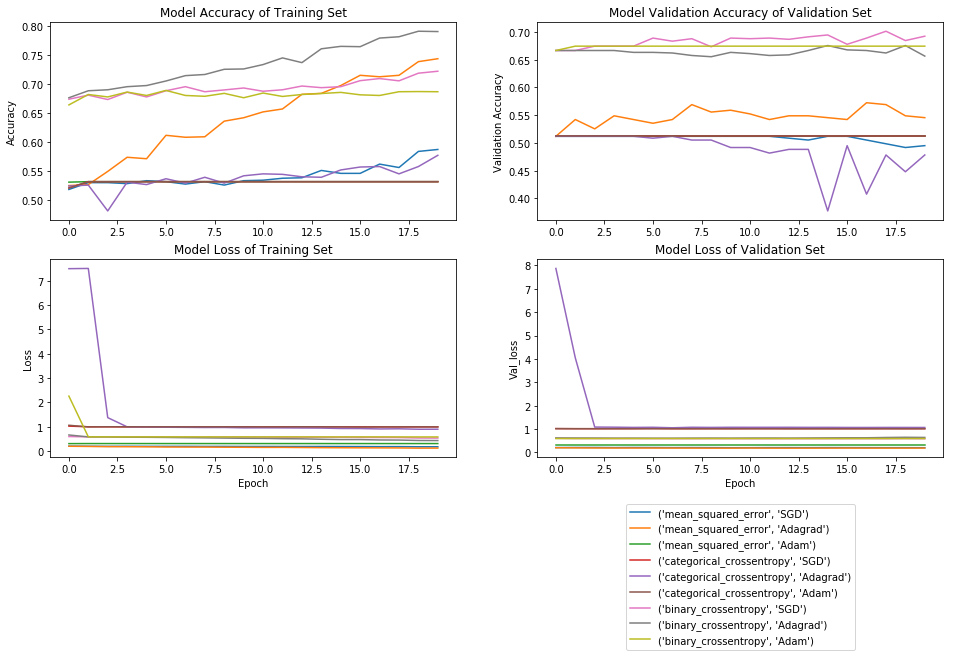

In [107]:
fig = plt.figure(figsize=(16,8))

for i, history in enumerate(test_combination_histories):
    ax1 = fig.add_subplot(2,2,1)
    ax1.plot(history.history['acc'], label=combo_names[i])
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Model Accuracy of Training Set')

    ax2 = fig.add_subplot(2,2,2)
    ax2.plot(history.history['val_acc'], label=combo_names[i])
    ax2.set_ylabel('Validation Accuracy')
    ax2.set_title('Model Validation Accuracy of Validation Set')
    
    ax3 = fig.add_subplot(2,2,3)
    ax3.plot(history.history['loss'], label=combo_names[i])
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.set_title('Model Loss of Training Set')
    
    ax4 = fig.add_subplot(2,2,4)
    ax4.plot(history.history['val_loss'], label=combo_names[i])
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Val_loss')
    ax4.set_title('Model Loss of Validation Set')
    ax4.legend(loc=8, bbox_to_anchor=(0.5, -1))
plt.show()

In [108]:
best_acc = max(test_combination_val_accs)
best_acc_idx = test_combination_val_accs.index(best_acc)
best_combo = combinations[best_acc_idx]
print ('The best loss-function/optimizer combination is ', combinations[best_acc_idx])

The best loss-function/optimizer combination is  ('binary_crossentropy', <keras.optimizers.SGD object at 0x2ad686f8a5f8>)


### PREDICTION

In [112]:
from keras.models import load_model
reduced_feature_model1_version1 = load_model("model1_checkpoint/Model1-reduced-feature-('binary_crossentropy', <keras.optimizers.SGD object at 0x2ad686f8a5f8>).h5")
reduced_feature_model1_version2 = load_model("model1_checkpoint/Model1-reduced-feature-version2('binary_crossentropy', <keras.optimizers.SGD object at 0x2ad686f8a5f8>).h5")

In [145]:
test_label_predicted_by_version1 = reduced_feature_model1_version1.predict_classes(test_data)
test_label_predicted_by_version2 = reduced_feature_model1_version2.predict_classes(test_data)

In [150]:
test_label_predicted_by_version1 = test_label_predicted_by_version1 + 1
test_label_predicted_by_version2 = test_label_predicted_by_version2 + 1

In [184]:
test_label_solution = pd.read_csv('solution_stg1_release.csv')

In [208]:
test_id_images = [x.split('/')[-1] for x in test_id_]
img_no_data = []
for img in test_label_solution.image_name.values:
    if img not in test_id_images:
        img_no_data.append(img)

In [210]:
test_label_solution = test_label_solution[test_label_solution.image_name.isin(img_no_data) == False]
subset = test_label_solution[['Type_1', 'Type_2', 'Type_3']]
test_label_solution = [list(x) for x in subset.values]

In [212]:
new_test_labels_solution = []
for label in test_label_solution:
    if label == [1, 0, 0]:
        label = 1
        new_test_labels_solution.append(label)
    elif label == [0, 1, 0]:
        label = 2
        new_test_labels_solution.append(label)
    else:
        label =3
        new_test_labels_solution.append(label)

        Y_test = np.array(new_test_labels_solution)

In [219]:
from sklearn.metrics import accuracy_score
accuracy_score_version1 = accuracy_score(Y_test, test_label_predicted_by_version1)
accuracy_score_version2 = accuracy_score(Y_test, test_label_predicted_by_version2)
print ('The accuracy obtained by running model1 with reduced feature version 1 is ', accuracy_score_version1)
print ('The accuracy obtained by running model1 with reduced feature version 2 is ', accuracy_score_version2)

The accuracy obtained by running model1 with reduced feature version 1 is  0.2485089463220676
The accuracy obtained by running model1 with reduced feature version 2 is  0.47713717693836977


In [221]:
model1_0_layer = load_model('model1_checkpoint/model1_add_0_layer.h5')
test_label_predicted_by_model1_0_layers = model1_0_layer.predict_classes(test_data)

In [222]:
accuracy_score_model1_0layer = accuracy_score(Y_test, test_label_predicted_by_model1_0_layers)
print (accuracy_score_model1_0layer)

0.2823061630218688
